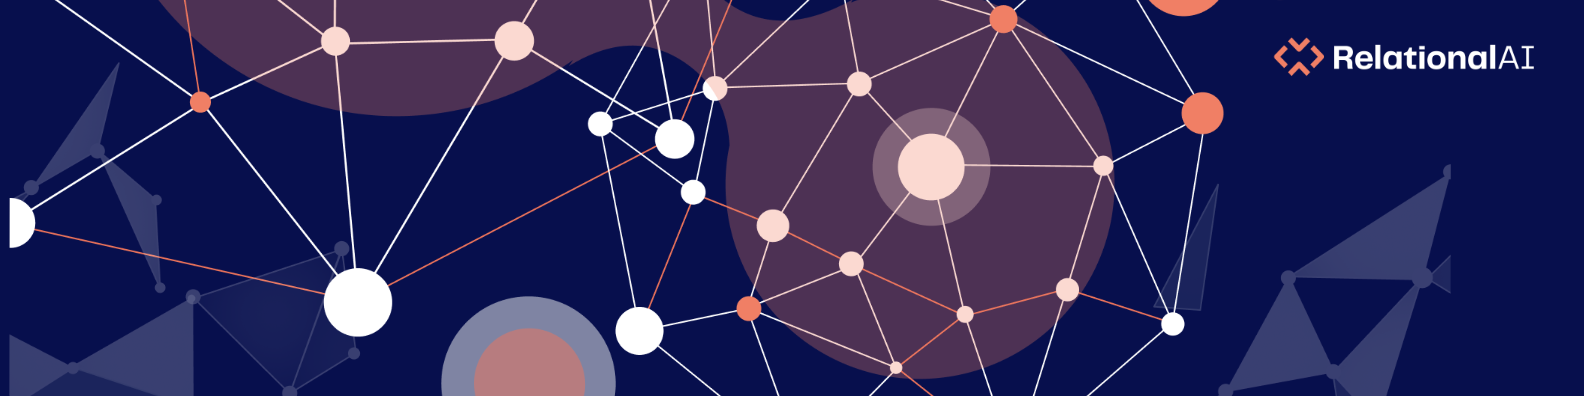 <!--Temporary solution to see the image in Github preview in private repo-->


<!-- <img src="assets/rai_banner.png"> This way Github preview should show image correctly for public repo -->



# Anti-Money-Laundering (AML) Detection
## Using Reasoning and Graph Analytics on Data from Multiple Banks to Detect Money Laundering

*Based on the 2020 case study from Banca d’Italia: "Rule-based Anti-Money Laundering in Financial Intelligence Units: Experience and Vision".*

The high-level decision tasks for the case:

1. **Task 1: Suspicion assessment**. Decide whether a financial *transaction* or a *case* meets a definition of "suspicious".
2. **Task 2: Suspicious offense determination**. Decide whether a suspicious *predicate offense* underlines a transaction or case.

Some reasoning rules are designed by financial analysts and domain engineers, while others are learnt from data, e.g., with statistical relational learning approaches.

The main subject of the case is a Suspicious Transaction Report (STR) and its assessment per Tasks 1 and 2 above.

We define the search for a typical laundering pattern as follows: _A person who is issuing a loan request to a bank of which he/she is the ultimate beneficial owner (UBO), may intend to launder unclean money via the bank._


## Modeling Knowledge Graph Entities and Relationships
We start by defining and importing all the Python packages that we will need, including the `relationalai` package. We then define a model object called `AMLDemoSF`.

In [ ]:
%pip install relationalai

In [2]:
import relationalai as rai
from relationalai.std.graphs import Graph
from relationalai.std.aggregates import sum, rank_asc
from relationalai.std import alias
import pandas as pd
from typing import Tuple

> **Note**. Models represent collections of objects. Objects, like Python objects, have types and properties, which we will define in a bit.

### Importing Data 
We import a synthetic dataset (inspired by the paper from 2020 mentioned above) from a set of Snowflake tables. The tables contain information about the direct ownership relationship between financial institutions, companies and people.

The next two code cells create and populate the tables we'll use.

In [3]:
provider = rai.Provider()

In [ ]:
provider.sql("""
begin
	create schema if not exists RAI_DEMO.AML;

	create or replace table RAI_DEMO.AML.BANK (
		ID NUMBER(18,0),
		NAME TEXT
	);

	create or replace table RAI_DEMO.AML.COMPANY (
		ID NUMBER(18,0),
		NAME TEXT
	);

	create or replace table RAI_DEMO.AML.PERSON (
		ID NUMBER(18,0),
		NAME TEXT,
		FAMILY_NAME TEXT
	);

	create or replace table RAI_DEMO.AML.EMPLOYMENT (
		EMPLOYEE_ID NUMBER(18,0),
		EMPLOYER_ID NUMBER(18,0),
		ROLE TEXT
	);

	create or replace table RAI_DEMO.AML.OWNERSHIP (
		OWNER_ID NUMBER(18,0),
		ASSET_ID NUMBER(18,0),
		PERCENT NUMBER(18,0)
	);

	insert into RAI_DEMO.AML.BANK (ID, NAME)
	values
	(11, 'MyBank'),
	(12, 'ACME Trust'),
	(13, 'People Bank'),
	(14, 'ACME Bank');

	insert into RAI_DEMO.AML.COMPANY (ID, NAME)
	values
	(1, 'NebulaTech Solutions'),
	(2, 'Quantum Dynamics Innovations'),
	(3, 'StellarSphere Enterprises'),
	(4, 'CyberNexus Systems'),
	(5, 'InfinityForge Technologies'),
	(6, 'PhoenixRise Ventures'),
	(7, 'CelestialWave Industries'),
	(8, 'NovaCore Innovations'),
	(9, 'DreamScape Enterprises'),
	(10, 'ElysiumTech Solutions');

	insert into RAI_DEMO.AML.OWNERSHIP (OWNER_ID, ASSET_ID, PERCENT)
	values
	(13, 12, 93),
	(12, 11, 23),
	(11, 14, 34),
	(11, 1, 70),
	(11, 2, 12),
	(11, 3, 65),
	(3, 4, 100),
	(3, 5, 40),
	(3, 6, 61),
	(6, 7, 40),
	(6, 8, 81),
	(6, 9, 3),
	(7, 14, 45),
	(8, 14, 15),
	(8, 10, 11),
	(23, 11, 32);

	insert into RAI_DEMO.AML.PERSON (ID, NAME, FAMILY_NAME)
	values
	(21, 'Tom', 'Family Doe'),
	(22, 'Bob', 'Family Doe'),
	(23, 'Anna', 'Family Doe'),
	(24, 'Mary', 'Family Doe');

	insert into RAI_DEMO.AML.EMPLOYMENT (EMPLOYEE_ID, EMPLOYER_ID, ROLE)
	values
	(22, 13, 'CEO');
end;
""")

[Row(anonymous block=None)]

> **Note**. We access data in Snowflake by simply passing our table location as `source` parameter while creating a model type in the format `<my_database.my_schema.my_table>`. `Company`, for instance, contains the data in a database called `RAI_DEMO`, schema `AML` and table `COMPANY`.

In [ ]:
model = rai.Model("AMLDemoSF", ensure_change_tracking=True)

Company = model.Type("Company", source = "RAI_DEMO.AML.COMPANY")
FinancialInstitution = model.Type("FinancialInstitution", source = "RAI_DEMO.AML.BANK")
Person = model.Type("Person", source = "RAI_DEMO.AML.PERSON")
Employment = model.Type("Employment", source = "RAI_DEMO.AML.EMPLOYMENT")
DirectOwnership = model.Type("DirectOwnership", source = "RAI_DEMO.AML.OWNERSHIP")

> **Note**. We connect to Snowflake and create a Snowpark session using the `rai init` command. A `data stream` between the tables and the `AMLDemoSF` model was created to stream the data from Snowflake to the RAI schema.

Here you can see a visualization of our base model:

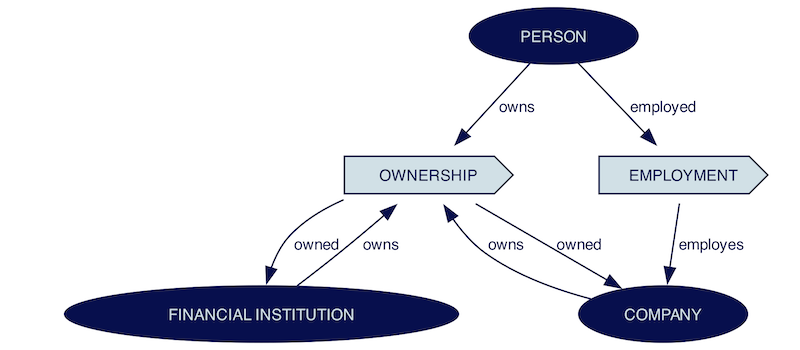

### Extending model with Types
Now we can add our own types to the model and populate them.

Note how we extend our `LegalEntity` type with all instances of banks, companies and people. `Employment` and `DirectOwnership` relationships rules can now use it to refer to any of the three and populate properties that hold objects, like `owner`, `employer`, etc.

Finally, we create `Family` instances from every value in `Person`.`family_name` property (column).

In [3]:
Family = model.Type("Family")
LegalEntity = model.Type("LegalEntity")

DerivedOwnership = model.Type("DerivedOwnership")
TotalOwnership = model.Type("TotalOwnership")
Control = model.Type("Control")

LegalEntity.extend(Company)
LegalEntity.extend(FinancialInstitution)
LegalEntity.extend(Person)

with model.rule():
    e = Employment()
    e.set(employer = LegalEntity(id = e.employer_id), employee = Person(id = e.employee_id))

with model.rule():
    do = DirectOwnership()
    do.set(owner = LegalEntity(id = do.owner_id), asset = LegalEntity(id = do.asset_id), part = do.percent/100)

with model.rule():
    p = Person()
    p.set(family = Family.add(name = p.family_name).set(LegalEntity))

Here you can see a visualization of our extended model:

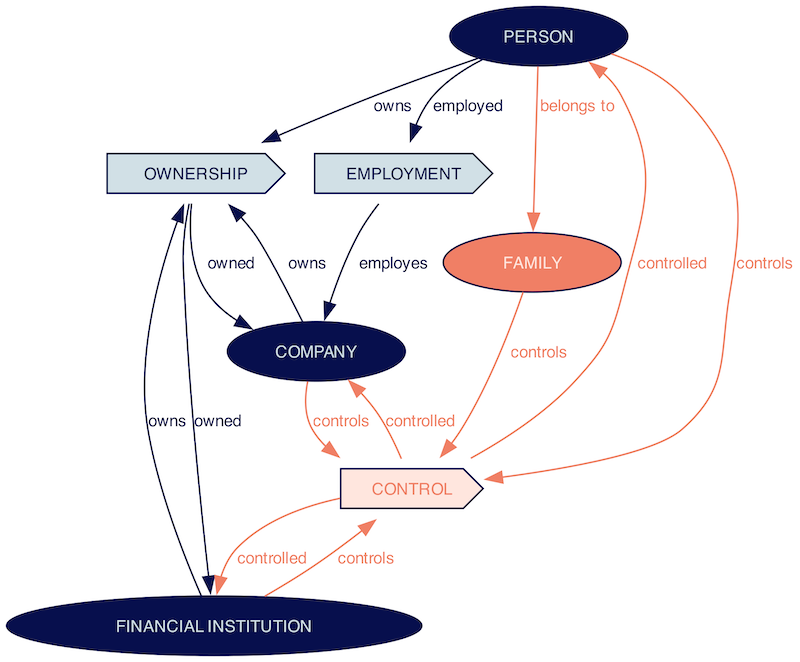

Let's write some queries now to get to know our data.

In [4]:
with model.query() as select:
    fi = FinancialInstitution()
    res = select(fi.id, fi.name)

res

In [5]:
with model.query() as select:
    c = Company()
    res = select(c.id, c.name)

res

In [6]:
with model.query() as select:
    p = Person()
    res = select(p) # select(p.id, p.name, alias(p.family.name, 'family name'))

res

In [7]:
with model.query() as select:
    e = Employment()
    res = select(alias(e.employee.name, 'employee'), alias(e.employer.name, 'employer'), e.role)

res.results

employee     employer role
0      Bob  People Bank  CEO

In [8]:
with model.query() as select:
    o = DirectOwnership()
    res = select(alias(o.owner.name, "owner"), alias(o.asset.name, "asset"), alias(o.part, "percent"))

res.results

owner                         asset  percent
0                  ACME Trust                        MyBank     0.23
1                        Anna                        MyBank     0.32
2    CelestialWave Industries                     ACME Bank     0.45
3                      MyBank                     ACME Bank     0.34
4                      MyBank          NebulaTech Solutions     0.70
5                      MyBank  Quantum Dynamics Innovations     0.12
6                      MyBank     StellarSphere Enterprises     0.65
7        NovaCore Innovations                     ACME Bank     0.15
8        NovaCore Innovations         ElysiumTech Solutions     0.11
9                 People Bank                    ACME Trust     0.93
10       PhoenixRise Ventures      CelestialWave Industries     0.40
11       PhoenixRise Ventures        DreamScape Enterprises     0.03
12       PhoenixRise Ventures          NovaCore Innovations     0.81
13  StellarSphere Enterprises            CyberNexus Systems     1.00
14  StellarSphere Enterprises    InfinityForge Technologies     0.40
15  StellarSphere Enterprises          PhoenixRise Ventures     0.61

### Adding our input parameters
Given the data above, we want to check if a person is requesting a loan from a bank which is controlled by that person or his family. So let's see whether this is the case for `Tom` requesting a `loan` from the `ACME Bank`.

In [9]:
activity_type = "loan"
person_name = "Tom"
bank_name = "ACME Bank"

### Visualizing the input data
Let's take a closer look at all the direct ownership relationships. We define a weighted graph called `direct_ownership_graph` and assign legal entities as well people to represent `nodes` in the graph. `Edges` represent the direct ownership relation. We use the ownership percentage as the weight of the relationship.

We mark Tom in red and the bank that he is requesting the loan from in yellow. Looking at only the input data, there does not seem to be a connection between the two.


In [10]:
direct_ownership_graph = Graph(model, weighted=True)
direct_ownership_graph.Node.extend(LegalEntity, label=LegalEntity.name)

with model.rule():
    p = Person(name = person_name)
    direct_ownership_graph.Node(p).set(focus='target')

with model.rule():
    direct_ownership_graph.Node(FinancialInstitution(name = bank_name)).set(focus='source')

with model.rule():
    o = DirectOwnership()
    e = direct_ownership_graph.Edge.add(o.owner, o.asset, weight=o.part)
    with direct_ownership_graph.Node(o.owner).focus == 'target':
        e.set(focus='target')

ownership_graph_style = {
        "node": {
            "color": lambda n : '#f07f65' if n.get('focus')=='target' else '#edb551' if n.get('focus')=='source' else '#92979c',
            "size": lambda n: 20 if n.get('focus')in['target','source'] else 10
        },
        "edge": {
            "color": lambda e: '#f07f65' if e.get('focus')=='target' else "#92979c",
            "label": lambda e: f'{(e.get("weight")*100):.2f}%',
            "size": lambda e: e['weight'] * 5
        }
    }

direct_ownership_graph.visualize(three=False, show_edge_label = True, style=ownership_graph_style).display(inline=True)

> **Tip**. This visualization shows us what known connections we have through ownership, but our Tom is not yet connected to anything in any way. Let's therefore extend our graph with additional knowledge.

## Augmenting the Knowledge Graph with additional 'Direct' and 'Indirect Relationships'
While Tom might not have any direct association with this bank, he or his family might still control it indirectly, which would be suspicious and we would want to flag. 
Notice here that the concept of “control” as well as “family” are not explicitly defined in our input data, we thus need to define it as part of our model. So let’s augment our knowledge graph with additional data, to see if this might change.

We do this by defining the concept of `control` both at the person as well as the family level.

### Extending direct ownership due to 100% control
We make the following assumptions on when to extend direct relationships due to 'control' relationships:
- If a person is the CEO of a company, it implies that she has 100% control of the company.
- A family owns everything that its members own.



> **Note**. We first create 2 rules, one is looking at `Employment` instances for a `role` of CEO, to connect `employee` and `employer` through `isCeoAt` property. We then use it to say that there is a `DirectOwnership` instance of `1.0` value from CEO to the company.
> 
> Another rule then creates `DirectOwnership` instances of `1.0` from every person's `family` property to himself.

In [ ]:
with model.rule():
    e = Employment(role = "CEO")
    e.employee.set(isCeoAt = e.employer)

# CEO of a company has 100% ownership
with model.rule():
    p = Person()
    DirectOwnership.add(owner = p, asset = p.isCeoAt).set(part = 1.0)


# Family owns everything that its members own
with model.rule():
    p = Person()
    DirectOwnership.add(owner = p.family, asset = p).set(part = 1.0)


#### Visualizing the new edges due to 100% control from CEO or via family members
Notice how knowing the family members, we can determine the overall relationship of family with a financial institution. Given that Tom belongs to the Doe Family, everything he owns is also owned by his family, so we mark the Doe Family node also as red.

In [12]:
with model.rule():
    p = Person(name = person_name)
    direct_ownership_graph.Node(p.family).set(focus='target')

vis = direct_ownership_graph.visualize(three=False, show_edge_label = True, style=ownership_graph_style)
vis.display(inline=True)

> **Tip**. Our ownership graph looks much more connected now! However, it is still unclear if there is anything suspicious in Tom taking a loan from the "ACME Bank". So let's keep adding knowledge to help interpret our graph.

### Additional derived `control` relationships
Let's infer additional relationships due to some broadly accepted formulations, also present in logic programming contexts:
- A company (or a person/family) X controls a company Y, if X directly owns more than 50% of Y

In [13]:
# rule 1
with model.rule():
    o = DirectOwnership()
    o.part > 0.5
    c = Control.add(controller = o.owner, controlled = o.asset)

In [14]:
control_graph = Graph(model)
control_graph.Node.extend(LegalEntity, label = LegalEntity.name)

with model.rule():
    p = Person(name = person_name)
    control_graph.Node(p).set(focus='target')
    control_graph.Node(p.family).set(focus='target')

with model.rule():
    bank = FinancialInstitution(name=bank_name)
    with model.not_found():
        Control(controller=Person(name = person_name).family, controlled=bank)
    control_graph.Node(bank).set(focus='source')

with model.rule():
    c = Control()
    e = control_graph.Edge.add(c.controller, c.controlled)
    with control_graph.Node(c.controller).focus=='target':
        e.set(focus='target')
        with c.controlled == LegalEntity(Company|FinancialInstitution):
            control_graph.Node(c.controlled).set(focus='controlled')

control_graph_style = {
        "node": {
            "color": lambda n : '#f07f65' if n.get('focus')in ['target', 'controlled'] else '#edb551' if n.get('focus')=='source' else '#92979c',
            "size": lambda n: 20 if n.get('focus')in['target','source', 'controlled'] else 10
        },
        "edge": {
            "color": lambda e: "#f07f65" if e.get('focus')=='target' else '#92979c',
            "size": lambda e: 5 if e.get('focus')=='target' else 1
        }
    }

vis = control_graph.visualize(three=False, style=control_graph_style)
vis.display(inline=True) # interactive visualization can be commented out in favor of zoomed in inserted image


> **Tip**. This visualization now shows us how Tom's family members control some banks and companies, but "ACME Bank" is not yet one of them. We therefore will add another rule.

Let's add one more rule:
- X controls a set of companies that jointly (i.e., summing the share amounts), and possibly together with X, own more than 50% of Y

> **Note**. We now introduce a recursive rule to propagate `Control` relationship further. Using `model.match(multiple=True)` we first get all of `DirectOwnership` instances where `owner` is either an entity already `controlled` by entity X, or is X itself. Then `sum` of all the `part`s for every pair of `controller` and `asset` is checked to be greater than `0.5`. If that's the case - we get a new `Control` relationship.

In [15]:
# rule 2
with model.rule():
    ctrl = Control()
    o = DirectOwnership()
    with model.match(multiple=True) as all_ownerships:
        with o.owner == ctrl.controlled: all_ownerships.add(o)
        with o.owner == ctrl.controller: all_ownerships.add(o)
    sum(all_ownerships, all_ownerships.part, per = [ctrl.controller, all_ownerships.asset]) > 0.5
    c = Control.add(controller = ctrl.controller, controlled = all_ownerships.asset)

In [16]:
vis = control_graph.visualize(three=False, style=control_graph_style)
vis.display(inline=True) # interactive visualization can be commented out in favor of zoomed in inserted image

> **Tip**. Look, family Doe controls more and more! But the link to "ACME Bank" is still missing.

### Deriving accumulated ownership using recursion
Add rules to accumulate direct and indirect ownerships that Tom exerts on ACME Bank, along all possible ownership paths.


> **Note**. Another recursive rule now uses two `Ownership` instances to derive sub-part that entity owns through another entity. We introduce `DerivedOwnership` which is identified additionally by `sub_owner`, as there can be multiple paths - entities, through which ownership can be derived. Note how we then add both instances of `Ownership` used to create a `DerivedOwnership` to a multi-valued property `sub_source`, using `extend` method. We will use it later to explain the numbers.

In [17]:
# Initialize recursive derived ownership rule with known direct ownerships
with model.rule():
    DirectOwnership().set(DerivedOwnership)

# Recursively add every path from E1 to E3 via E2,
# where E1 -> E2 is a known direct ownership and E2 -> E3 is previously derived path
with model.rule():
    o = DirectOwnership()
    sub_o = TotalOwnership(owner = o.asset)
    # Keyed not only by owner and asset, but also by intermediate sub_owner
    new = DerivedOwnership.add(owner = o.owner, sub_owner = o.asset, asset = sub_o.asset).set(part = o.part * sub_o.part)
    new.sub_source.extend([o, sub_o])

# Sum up all of the derived paths from E1 to E2 to identify the total ownership
with model.rule():
    do = DerivedOwnership()
    to = TotalOwnership.add(owner = do.owner, asset = do.asset).set(part = sum(do, do.part, per = [do.owner, do.asset]))
    to.sub_source.add(do)

Let's take a look at all the ownerships that we just derived.

**Note**: because we included the `sub_owner` in our results, we only get derived ownerships and direct ones are excluded

In [ ]:
with model.query() as select:
    d = DerivedOwnership()
    d.owner.name == 'Anna'
    res = select(alias(d.owner.name, 'owner'), alias(d.sub_owner.name,'sub_owner'), alias(d.asset.name, 'asset'), alias(d.part*100, 'derived (%)'))

res

> **Tip**. Quite a lot of new indirectly-owned assets (and that's for Anna alone).

### Extending `Control` relationship with accumulated ownership
Let's now use total values that we get from summing up all of the possible paths in order identify more controlling relationships

> **Note**. We now want to repeat the same rules, defining `Control` relationship, but using new accumulated ownership values from `TotalOwnership` instead of `DirectOwnership`.

In [19]:
with model.rule():
    o = TotalOwnership()
    o.part > 0.5
    c = Control.add(controller = o.owner, controlled = o.asset)
    c.reason.add(1) #used later for visualization purposes

with model.rule():
    ctrl = Control()
    o = TotalOwnership()
    with model.match(multiple=True) as all_ownerships:
        with o.owner == ctrl.controlled: all_ownerships.add(o)
        with o.owner == ctrl.controller: all_ownerships.add(o)
    sum(all_ownerships, all_ownerships.part, per = [ctrl.controller, all_ownerships.asset]) > 0.5
    c = Control.add(controller = ctrl.controller, controlled = all_ownerships.asset)
    c.reason.add(2)

In [20]:
control_graph.visualize(three=False, style=control_graph_style).display(inline=True)

> **Tip**. Now here's a surprise, it looks like ACME Bank is actually controlled by the Doe Family!

### Overall Pattern:

  1. Anna directly owns 0.32 of My Bank and Bob indirectly owns 0.21 = 1 * 0.93 * 0.23 of My Bank.
  2. In total, family Doe controls My Bank owning 0.53 of the shares.
  3. My Bank, in turn, controls ACME Bank holding 0.34 of the shares directly and controlling Phoenix Ventures company with 0.30 of the shares via a pyramidal shareholding structure, probably set up to obfuscate the connection between the two companies.
    
**Conclusion: family Doe controls ACME Bank.**

In [21]:
with model.query() as select:
    p = Person(name = person_name)
    fi = FinancialInstitution(name = bank_name)
    ctrl = Control(controller = p.family, controlled = fi)
    res = select(alias(p.family.name, 'controller'), alias(fi.name, 'controlled'))

res

## Full explanation of the specific financial fraudulent schemes
Let's query all relevant ownerships from which the accumulated family ownership of the ACME Bank got derived.

In [22]:
with model.rule():
    TotalOwnership().set(type='total')
    DirectOwnership().set(type='direct')
    d = DerivedOwnership()
    d.set(type=d.sub_owner.name)

max_depth = 5 # set the level of sub-ownerships to be explained
with model.query(dynamic=True) as select:
    main_own = TotalOwnership(owner=Person(name = person_name).family, asset=FinancialInstitution(name = bank_name))
    with model.match(multiple=True, dynamic=True) as rel_ownerships:
        with model.case():
            rel_ownerships.add(main_own, own=main_own, order = 0, type=main_own.type)
        for i in range(max_depth):
            with model.case(dynamic=True):
                own = main_own
                rank = 0
                for j in range(i):
                    rank = rank_asc(own.sub_source, per = [own])*(10**(i-j)) + rank
                    own = own.sub_source
                sub_own = own.sub_source
                rank = rank + rank_asc(sub_own, per = [own])
                rel_ownerships.add(sub_own, own=sub_own, order = rank, type = sub_own.type)
    res = select(rel_ownerships.order, alias(rel_ownerships.own.owner.name, 'owner'), alias(rel_ownerships.own.asset.name, 'asset'), rel_ownerships.own.part, alias(rel_ownerships.type, 'type/sub owner'))
pd.DataFrame(res.results, columns = ['owner', 'asset', 'part', 'type/sub owner'])

owner        asset      part             type/sub owner
0    Family Doe    ACME Bank  0.245351                      total
1    Family Doe    ACME Bank  0.098297                        Bob
2    Family Doe    ACME Bank  0.147054                       Anna
3           Bob    ACME Bank  0.098297                      total
4    Family Doe          Bob  1.000000                     direct
5          Anna    ACME Bank  0.147054                      total
6    Family Doe         Anna  1.000000                     direct
7           Bob    ACME Bank  0.098297                People Bank
8          Anna    ACME Bank  0.147054                     MyBank
9   People Bank    ACME Bank  0.098297                      total
10          Bob  People Bank  1.000000                     direct
11         Anna       MyBank  0.320000                     direct
12       MyBank    ACME Bank  0.459545                      total
13  People Bank    ACME Bank  0.098297                 ACME Trust
14       MyBank    ACME Bank  0.119545  StellarSphere Enterprises
15       MyBank    ACME Bank  0.340000                     direct

### Relevant ownerships graph

In [23]:
ownerships_graph = Graph(model, weighted=True)
Node, Edge = ownerships_graph.Node, ownerships_graph.Edge
Node.extend(LegalEntity, label = LegalEntity.name)

# Assign `value` to every node of the graph having some ownership of the FI of interest
with model.rule():
    fi = FinancialInstitution(name = bank_name)
    to = TotalOwnership(asset = fi)
    Node(to.owner).set(value = to.part)
    Node(fi).set(value = 1.0, focus = 'target')

with model.rule():
    p = Person()
    Edge.add(Node(p.family), Node(p), kind = 'in family')

with model.rule():
    p = Person()
    Edge(Node(p), Node(p.isCeoAt)).set( kind = 'ceo')

with model.rule():
    p = Person(name = person_name)
    Node(p).set(focus = 'target')
    Node(p.family).set(focus = 'target')

# Using TotalOwnership connect family of the person of interest with the FI of interest
with model.rule():
    fam = Person(name = person_name).family
    fi = FinancialInstitution(name = bank_name)
    Edge.add(fam, fi, ownership = TotalOwnership(owner = fam, asset = fi))

# Add edges relevant to show where existing edges (ownerships) got derived from
with model.rule():
    e = Edge()
    own = e.ownership
    with own.sub_source.sub_owner:
        sub_own = TotalOwnership(owner=own.sub_source.owner, asset=own.sub_source.sub_owner)
        Edge.add(sub_own.owner, sub_own.asset, ownership = sub_own)
        sub_sub_own = TotalOwnership(owner=own.sub_source.sub_owner, asset=own.sub_source.asset)
        Edge.add(sub_sub_own.owner, sub_sub_own.asset, ownership = sub_sub_own)

# Add `weight`
with model.rule():
    e = Edge()
    e.set(weight = TotalOwnership(owner = e.from_, asset = e.to).part)

ownerships_graph.visualize(three=False, show_edge_label = True,
    style={
        "node": {
            "color": lambda n : '#f07f65' if n.get('focus') == 'target' else '#92979c',
            "size": lambda n: n.get("value")**(1/2) * 50 if n.get("value") else 10
        },
        "edge": {
            "color": "#3baca3",
            "label": lambda e: "family member" if e.get("kind") == "in family" else "CEO at" if e.get("kind") == "ceo" else f'{e.get("weight")*100:.2f}%',
            "size": lambda e: e['weight'] * 5
        }
    }).display(inline=True)

### Relevant Control Graph

In [24]:
control_graph = Graph(model)
Node, Edge = control_graph.Node, control_graph.Edge
Node.extend(LegalEntity, label = LegalEntity.name)

# Assign `value` to every node of the graph having some ownership of the FI of interest
with model.rule():
    fi = FinancialInstitution(name = bank_name)
    to = TotalOwnership(asset = fi)
    Node(to.owner).set(value = to.part)
    Node(fi).set(value = 1.0, focus = 'target')

with model.rule():
    p = Person()
    Edge.add(Node(p.family), Node(p), kind = 'in family')

with model.rule():
    p = Person()
    Edge(Node(p), Node(p.isCeoAt)).set( kind = 'ceo')

with model.rule():
    p = Person(name = person_name)
    Node(p).set(focus = 'target')
    Node(p.family).set(focus = 'target')

with model.rule():
    p = Person(name = person_name)
    c = Control(controller = p.family)
    c.controlled != p
    Node(c.controlled).set(focus="controlled")
    with TotalOwnership(owner = c.controlled, asset=FinancialInstitution(name=bank_name)):
        Edge.add(c.controller, c.controlled)

with model.rule():
    n = Node(focus = "controlled")
    n == LegalEntity(Company|FinancialInstitution)
    fi = FinancialInstitution(name = bank_name)
    TotalOwnership(owner = n, asset = fi)
    c = Control(controller = n)
    TotalOwnership(owner = c.controlled, asset = fi)
    Edge.add(n, c.controlled)

with model.rule():
    n = Node(focus = "controlled")
    n == LegalEntity(Company|FinancialInstitution)
    fi = FinancialInstitution(name = bank_name)
    Control(controller = n, controlled = fi)
    Edge.add(n, fi)

with model.rule():
    e = Edge()
    Control(controller = e.from_, controlled = e.to).reason == 1
    e.set(kind = "direct control")

control_graph.visualize(three=False, show_edge_label=True,
    style={
        "node": {
            "color": lambda n : '#f07f65' if n.get('focus') == 'target' else '#edb551' if n.get('focus')=='controlled' else '#92979c',
            "size": lambda n: n.get("value")**(1/2) * 50 if n.get("value") else 10
        },
        "edge": {
            "color": lambda e: "#f07f65" if e.get('kind') == 'direct control' else '#edb551',
            "label": lambda e: "family member" if e.get("kind") == "in family" else "CEO at" if e.get("kind") == "ceo" else '',
            "size": 2
        }
    }).display(inline=True)

## Writing results back to Snowflake

As a final step, we want to provide a way to get the result of our analysis from Snowflake, where we are getting the data from. In order to do that, we create a stored procedure, which returns all of the `Control` relationships identified.

In [25]:
@model.export("rai_demo.aml")
def detect_control() -> Tuple[str, str]:
    ctrl = Control()
    return ctrl.controller.name, ctrl.controlled.name

> **Note**. Using `@model.export()` we create a stored procedure called `detect_control` in the `rai_demo` database, `aml` schema. We can now execute it right here using `model.resources._exec()`.

In [26]:
controls = model.resources._exec("call rai_demo.aml.detect_control();")
pd.DataFrame(controls, columns=['controller', 'controlled'])

controller                  controlled
0                      MyBank        NovaCore Innovations
1                      MyBank  InfinityForge Technologies
2                      MyBank        PhoenixRise Ventures
3                      MyBank        NebulaTech Solutions
4                      MyBank          CyberNexus Systems
5                      MyBank                   ACME Bank
6                      MyBank   StellarSphere Enterprises
7                      MyBank    CelestialWave Industries
8                  Family Doe                         Tom
9                  Family Doe                      MyBank
10                 Family Doe        NovaCore Innovations
11                 Family Doe  InfinityForge Technologies
12                 Family Doe        PhoenixRise Ventures
13                 Family Doe                 People Bank
14                 Family Doe        NebulaTech Solutions
15                 Family Doe          CyberNexus Systems
16                 Family Doe                   ACME Bank
17                 Family Doe                        Mary
18                 Family Doe   StellarSphere Enterprises
19                 Family Doe    CelestialWave Industries
20                 Family Doe                        Anna
21                 Family Doe                  ACME Trust
22                 Family Doe                         Bob
23       PhoenixRise Ventures        NovaCore Innovations
24                People Bank                  ACME Trust
25  StellarSphere Enterprises        NovaCore Innovations
26  StellarSphere Enterprises        PhoenixRise Ventures
27  StellarSphere Enterprises          CyberNexus Systems
28  StellarSphere Enterprises                   ACME Bank
29  StellarSphere Enterprises    CelestialWave Industries
30                        Bob                      MyBank
31                        Bob        NovaCore Innovations
32                        Bob  InfinityForge Technologies
33                        Bob        PhoenixRise Ventures
34                        Bob                 People Bank
35                        Bob        NebulaTech Solutions
36                        Bob          CyberNexus Systems
37                        Bob                   ACME Bank
38                        Bob   StellarSphere Enterprises
39                        Bob    CelestialWave Industries
40                        Bob                  ACME Trust